## **XGBoost from Scratch**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## XGBoostTree Class

This class implements a single decision tree using XGBoost's algorithm principles. Key features include:

### Parameters:
- `max_depth`: Maximum depth of the tree (default: 6)
- `min_child_weight`: Minimum sum of instance weight needed in a child (default: 1.0)
- `gamma`: Minimum loss reduction required for split (default: 0.0)
- `lambda_l2`: L2 regularization term (default: 1.0)
- `min_samples_split`: Minimum samples required to split a node (default: 10)

### Key Methods:
1. `_calc_leaf_value`: Calculates optimal leaf value using XGBoost's weight formula
2. `_calc_gain`: Implements XGBoost's gain formula for split evaluation
3. `_find_best_split`: Uses exact greedy algorithm to find the best split
4. `_build_tree`: Recursively constructs the tree structure
5. `fit`: Builds the tree using gradients and hessians
6. `predict`: Makes predictions using the constructed tree

## XGBoostClassifier Class

This class implements the full XGBoost classifier using multiple trees in an ensemble.

### Parameters:
- `n_estimators`: Number of boosting rounds (default: 100)
- `max_depth`: Maximum depth of each tree (default: 6)
- `learning_rate`: Step size shrinkage (default: 0.3)
- `min_child_weight`: Minimum sum of instance weight in a child (default: 1.0)
- `gamma`: Minimum loss reduction for split (default: 0.0)
- `lambda_l2`: L2 regularization term (default: 1.0)
- `colsample_bytree`: Subsample ratio of columns per tree (default: 1.0)
- `subsample`: Subsample ratio of training instances (default: 1.0)
- `random_state`: Random seed for reproducibility (default: None)

### Key Features:
1. **Multi-class Classification**: Handles multiple classes using one-vs-rest approach
2. **Gradient and Hessian Calculation**: Implements second-order approximation
3. **Feature Sampling**: Implements column subsampling per tree
4. **Instance Sampling**: Implements row subsampling
5. **Regularization**: L2 regularization and minimum gain threshold

### Key Methods:
1. `_compute_gradients_hessians`: Calculates first and second order derivatives
2. `_softmax`: Implements softmax function for probability conversion
3. `fit`: Trains the model iteratively building trees
4. `predict_proba`: Predicts class probabilities
5. `predict`: Predicts class labels

## Implementation Details

The implementation follows XGBoost's key principles:
- Uses second-order gradient optimization
- Implements exact greedy split finding
- Includes regularization terms
- Supports feature and instance sampling
- Handles multi-class classification using softmax

In [5]:
class XGBoostTree:
    """Single tree implementation using XGBoost algorithm"""
    def __init__(
        self,
        max_depth=6,
        min_child_weight=1.0,
        gamma=0.0,
        lambda_l2=1.0,
        min_samples_split=10
    ):
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight
        self.gamma = gamma
        self.lambda_l2 = lambda_l2
        self.min_samples_split = min_samples_split
        self.tree = None

    def _calc_leaf_value(self, sum_grad, sum_hess):
        """Calculate leaf value using XGBoost formula"""
        return -sum_grad / (sum_hess + self.lambda_l2)

    def _calc_gain(
        self,
        left_grad,
        left_hess,
        right_grad,
        right_hess,
        sum_grad,
        sum_hess
    ):
        """Calculate gain for a split using XGBoost formula"""
        gain = 0
        if left_hess >= self.min_child_weight:
            gain += (left_grad ** 2) / (left_hess + self.lambda_l2)
        if right_hess >= self.min_child_weight:
            gain += (right_grad ** 2) / (right_hess + self.lambda_l2)
        if sum_hess >= self.min_child_weight:
            gain -= (sum_grad ** 2) / (sum_hess + self.lambda_l2)
        gain = gain / 2.0 - self.gamma
        return gain

    def _find_best_split(self, X, gradients, hessians, feature_mask=None):
        """Find best split using XGBoost's exact greedy algorithm"""
        best_gain = 0.0
        best_feature = None
        best_threshold = None

        sum_grad = np.sum(gradients)
        sum_hess = np.sum(hessians)

        if feature_mask is None:
            feature_mask = np.ones(X.shape[1], dtype=bool)

        for feature in range(X.shape[1]):
            if not feature_mask[feature]:
                continue

            sort_idx = np.argsort(X[:, feature])
            sorted_feature = X[sort_idx, feature]
            sorted_gradients = gradients[sort_idx]
            sorted_hessians = hessians[sort_idx]

            left_grad = np.cumsum(sorted_gradients)[:-1]
            left_hess = np.cumsum(sorted_hessians)[:-1]
            right_grad = sum_grad - left_grad
            right_hess = sum_hess - left_hess

            unique_values = np.unique(sorted_feature)[:-1]
            
            for threshold in unique_values:
                split_mask = sorted_feature <= threshold
                n_left = np.sum(split_mask)
                n_right = len(split_mask) - n_left

                if n_left < self.min_samples_split or n_right < self.min_samples_split:
                    continue

                gain = self._calc_gain(
                    left_grad[n_left-1],
                    left_hess[n_left-1],
                    right_grad[n_left-1],
                    right_hess[n_left-1],
                    sum_grad,
                    sum_hess
                )

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _build_tree(self, X, gradients, hessians, depth=0, feature_mask=None):
        """Recursively build the tree"""
        if depth >= self.max_depth:
            return self._calc_leaf_value(np.sum(gradients), np.sum(hessians))

        feature, threshold, gain = self._find_best_split(X, gradients, hessians, feature_mask)

        if feature is None or gain <= 0:
            return self._calc_leaf_value(np.sum(gradients), np.sum(hessians))

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        left_tree = self._build_tree(
            X[left_mask],
            gradients[left_mask],
            hessians[left_mask],
            depth + 1,
            feature_mask
        )
        right_tree = self._build_tree(
            X[right_mask],
            gradients[right_mask],
            hessians[right_mask],
            depth + 1,
            feature_mask
        )

        return {
            'feature': feature,
            'threshold': threshold,
            'left': left_tree,
            'right': right_tree,
            'gain': gain
        }

    def fit(self, X, gradients, hessians, feature_mask=None):
        """Fit the tree"""
        self.tree = self._build_tree(X, gradients, hessians, feature_mask=feature_mask)

    def predict(self, X):
        """Make predictions"""
        return np.array([self._predict_single(x, self.tree) for x in X])

    def _predict_single(self, x, tree):
        """Predict single instance"""
        if not isinstance(tree, dict):
            return tree
        if x[tree['feature']] <= tree['threshold']:
            return self._predict_single(x, tree['left'])
        return self._predict_single(x, tree['right'])

class XGBoostClassifier:
    """XGBoost classifier implementation"""
    def __init__(
        self,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.3,
        min_child_weight=1.0,
        gamma=0.0,
        lambda_l2=1.0,
        colsample_bytree=1.0,
        subsample=1.0,
        random_state=None
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.min_child_weight = min_child_weight
        self.gamma = gamma
        self.lambda_l2 = lambda_l2
        self.colsample_bytree = colsample_bytree
        self.subsample = subsample
        self.random_state = random_state
        
        self.trees = []
        self.n_classes = None
        
        if random_state is not None:
            np.random.seed(random_state)

    def _compute_gradients_hessians(self, y_true, y_pred):
        """Compute gradients and hessians for multi-class log loss"""
        probas = self._softmax(y_pred)
        gradients = probas.copy()
        for i in range(len(y_true)):
            gradients[i, int(y_true[i])] -= 1
        hessians = probas * (1 - probas)
        return gradients, hessians

    def _softmax(self, x):
        """Compute softmax probabilities"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def fit(self, X, y):
        """Fit the XGBoost model"""
        self.n_classes = len(np.unique(y))
        n_samples = len(X)

        y_pred = np.zeros((n_samples, self.n_classes))

        for _ in range(self.n_estimators):
            gradients, hessians = self._compute_gradients_hessians(y, y_pred)
            
            n_features = int(X.shape[1] * self.colsample_bytree)
            feature_mask = np.random.choice(
                [True, False],
                size=X.shape[1],
                p=[self.colsample_bytree, 1-self.colsample_bytree]
            )

            sample_mask = np.random.rand(n_samples) < self.subsample
            if not np.any(sample_mask):
                sample_mask[np.random.randint(n_samples)] = True

            trees_this_round = []
            
            for k in range(self.n_classes):
                tree = XGBoostTree(
                    max_depth=self.max_depth,
                    min_child_weight=self.min_child_weight,
                    gamma=self.gamma,
                    lambda_l2=self.lambda_l2
                )
                
                tree.fit(
                    X[sample_mask],
                    gradients[sample_mask, k],
                    hessians[sample_mask, k],
                    feature_mask
                )
                
                update = tree.predict(X)
                y_pred[:, k] += self.learning_rate * update
                
                trees_this_round.append(tree)
            
            self.trees.append(trees_this_round)

        return self

    def predict_proba(self, X):
        """Predict class probabilities"""
        raw_predictions = np.zeros((len(X), self.n_classes))
        
        for trees_this_round in self.trees:
            for k, tree in enumerate(trees_this_round):
                raw_predictions[:, k] += self.learning_rate * tree.predict(X)
        
        return self._softmax(raw_predictions)

    def predict(self, X):
        """Predict classes"""
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

This class implements common classification metrics from scratch, similar to scikit-learn's classification report functionality. It calculates and formats various performance metrics for multi-class classification:

### Key Metrics Calculated:
- **Confusion Matrix**: Computed for all classes
- **Precision**: Ratio of true positives to predicted positives (TP/(TP+FP))
- **Recall**: Ratio of true positives to actual positives (TP/(TP+FN))
- **F1-score**: Harmonic mean of precision and recall
- **Accuracy**: Overall prediction accuracy
- **Support**: Number of samples per class

The class provides both macro-averaging (simple average across classes) and weighted-averaging (weighted by class support) of metrics. The `generate_report()` method produces a formatted report similar to sklearn's classification_report.

In [8]:
class ClassificationMetrics:
    """Implementation of classification metrics from scratch"""
    def __init__(self, y_true: np.ndarray, y_pred: np.ndarray):
        self.y_true = y_true
        self.y_pred = y_pred
        self.classes = np.unique(np.concatenate([y_true, y_pred]))
        self.n_classes = len(self.classes)
        
        self.confusion_matrix = self._compute_confusion_matrix()
        
    def _compute_confusion_matrix(self) -> np.ndarray:
        """Compute confusion matrix"""
        cm = np.zeros((self.n_classes, self.n_classes), dtype=int)
        for i in range(len(self.y_true)):
            cm[int(self.y_true[i]), int(self.y_pred[i])] += 1
        return cm
    
    def precision_recall_f1(self) -> dict:
        """Calculate precision, recall and f1 for each class"""
        metrics = {}
        
        for class_idx in range(self.n_classes):
            tp = self.confusion_matrix[class_idx, class_idx]
            fp = np.sum(self.confusion_matrix[:, class_idx]) - tp
            fn = np.sum(self.confusion_matrix[class_idx, :]) - tp
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            metrics[class_idx] = {
                'precision': precision,
                'recall': recall,
                'f1-score': f1,
                'support': np.sum(self.confusion_matrix[class_idx, :])
            }
            
        return metrics
    
    def accuracy(self) -> float:
        """Calculate overall accuracy"""
        return np.sum(np.diag(self.confusion_matrix)) / np.sum(self.confusion_matrix)
    
    def macro_average(self, metrics: dict) -> dict:
        """Calculate macro average of metrics"""
        macro_avg = {
            'precision': 0.0,
            'recall': 0.0,
            'f1-score': 0.0,
            'support': np.sum([m['support'] for m in metrics.values()])
        }
        
        for m in metrics.values():
            macro_avg['precision'] += m['precision']
            macro_avg['recall'] += m['recall']
            macro_avg['f1-score'] += m['f1-score']
        
        for key in ['precision', 'recall', 'f1-score']:
            macro_avg[key] /= self.n_classes
            
        return macro_avg
    
    def weighted_average(self, metrics: dict) -> dict:
        """Calculate weighted average of metrics"""
        total_support = sum(m['support'] for m in metrics.values())
        weighted_avg = {
            'precision': 0.0,
            'recall': 0.0,
            'f1-score': 0.0,
            'support': total_support
        }
        
        for class_idx, m in metrics.items():
            weight = m['support'] / total_support
            weighted_avg['precision'] += m['precision'] * weight
            weighted_avg['recall'] += m['recall'] * weight
            weighted_avg['f1-score'] += m['f1-score'] * weight
            
        return weighted_avg
    
    def generate_report(self) -> str:
        """Generate classification report similar to sklearn's"""
        metrics = self.precision_recall_f1()
        macro_avg = self.macro_average(metrics)
        weighted_avg = self.weighted_average(metrics)
        
        report = "\nClassification Report:\n"
        report += "              precision    recall  f1-score   support\n\n"
        
        for class_idx in range(self.n_classes):
            m = metrics[class_idx]
            report += f"       class {class_idx:2d}    {m['precision']:8.2f}  {m['recall']:8.2f}  {m['f1-score']:8.2f}  {m['support']:8d}\n"
        
        report += "\n"
        report += f"    macro avg     {macro_avg['precision']:8.2f}  {macro_avg['recall']:8.2f}  {macro_avg['f1-score']:8.2f}  {macro_avg['support']:8d}\n"
        report += f" weighted avg     {weighted_avg['precision']:8.2f}  {weighted_avg['recall']:8.2f}  {weighted_avg['f1-score']:8.2f}  {weighted_avg['support']:8d}\n"
        
        total_accuracy = self.accuracy()
        report += f"\nAccuracy: {total_accuracy:.4f}\n"
        report += f"Total samples: {np.sum(self.confusion_matrix)}\n"
        
        return report

This function creates a synthetic dataset for testing the XGBoost classifier. It generates 4 distinct classes with different geometric patterns:

- **Class 0**: Two overlapping Gaussian clusters
- **Class 1**: Diagonal strip with noise
- **Class 2**: Circular cluster with radius variation
- **Class 3**: Three separated Gaussian clusters

Parameters:
- `n_samples`: Total number of samples (default: 2000)
- `noise_level`: Amount of noise added to patterns (default: 0.4)

The function also adds random outliers (2% of data) and shuffles the final dataset to ensure randomness. Returns feature matrix X and labels y.

In [11]:
def generate_balanced_data(n_samples: int = 2000, noise_level: float = 0.4) -> tuple:
    """Generate moderately complex data with some overlap but clear patterns"""
    n_samples_per_class = n_samples // 4
    X = []
    y = []
    
    X.append(np.vstack([
        np.random.normal([-2, -2], noise_level, (n_samples_per_class//2, 2)),
        np.random.normal([-1, -1], noise_level, (n_samples_per_class//2, 2))
    ]))
    y.append(np.zeros(n_samples_per_class))
    
    x1 = np.random.uniform(-2, 2, n_samples_per_class)
    x2 = x1 + np.random.normal(0, noise_level, n_samples_per_class)
    X.append(np.column_stack([x1, x2]))
    y.append(np.ones(n_samples_per_class))
    
    theta = np.random.uniform(0, 2*np.pi, n_samples_per_class)
    r = 2 + np.random.normal(0, 0.2, n_samples_per_class)
    X.append(np.column_stack([
        r * np.cos(theta) + np.random.normal(0, noise_level/2, n_samples_per_class) + 2,
        r * np.sin(theta) + np.random.normal(0, noise_level/2, n_samples_per_class) + 2
    ]))
    y.append(np.full(n_samples_per_class, 2))
    
    centers = [[-2, 2], [0, 2], [2, 0]]
    X_class3 = []
    for center in centers:
        X_class3.append(
            np.random.normal(center, noise_level*0.8, (n_samples_per_class//3, 2))
        )
    X.append(np.vstack(X_class3))
    y.append(np.full(n_samples_per_class, 3))
    
    X = np.vstack(X)
    y = np.hstack(y)
    
    n_outliers = n_samples // 50
    outliers = np.random.uniform(-4, 4, (n_outliers, 2))
    outlier_labels = np.random.randint(0, 4, n_outliers)
    
    X = np.vstack([X, outliers])
    y = np.hstack([y, outlier_labels])
    
    idx = np.random.permutation(len(X))
    return X[idx], y[idx]

## Visualization Functions

Two visualization functions to evaluate the model's performance:

### `plot_confusion_matrix`
Displays the confusion matrix as a heatmap using seaborn, where:
- Darker blue indicates higher values
- Each cell shows the number of predictions
- Axes represent true vs predicted labels

### `plot_results`
Creates three visualization plots side by side:
1. **Raw Data**: Shows train (circles) and test (triangles) data points
2. **True Labels**: Displays actual class distribution with different colors
3. **Decision Boundaries**: Visualizes model's classification regions and boundaries

This helps to understand the data distribution and assess how well the model separates different classes.

In [14]:
def plot_confusion_matrix(cm: np.ndarray, title: str = 'Confusion Matrix') -> None:
    """Plot confusion matrix using seaborn"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_results(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, 
                y_test: np.ndarray, model: 'XGBoostClassifier') -> None:
    """Plot the data and model decision boundaries"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].scatter(X_train[:, 0], X_train[:, 1], c='gray', alpha=0.5, label='Train')
    axes[0].scatter(X_test[:, 0], X_test[:, 1], c='darkgray', alpha=0.5, marker='^', label='Test')
    axes[0].set_title('Raw Data')
    axes[0].legend()
    axes[0].grid(True)
    
    colors = plt.cm.tab10(np.linspace(0, 1, 4))
    for i in range(4):
        mask_train = y_train == i
        mask_test = y_test == i
        axes[1].scatter(X_train[mask_train, 0], X_train[mask_train, 1], 
                       c=[colors[i]], alpha=0.5, label=f'Class {i}')
        axes[1].scatter(X_test[mask_test, 0], X_test[mask_test, 1], 
                       c=[colors[i]], alpha=0.5, marker='^')
    axes[1].set_title('True Labels')
    axes[1].legend()
    axes[1].grid(True)
    
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axes[2].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.tab10)
    for i in range(4):
        mask = y_train == i
        axes[2].scatter(X_train[mask, 0], X_train[mask, 1], 
                       c=[colors[i]], alpha=0.5, label=f'Class {i}')
    axes[2].set_title('XGBoost Decision Boundary')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

Training XGBoost model...
Making predictions...

Training Set Performance:

Classification Report:
              precision    recall  f1-score   support

       class  0        0.89      0.95      0.92       397
       class  1        0.91      0.87      0.89       412
       class  2        0.96      0.88      0.92       423
       class  3        0.91      0.97      0.94       398

    macro avg         0.92      0.92      0.92      1630
 weighted avg         0.92      0.92      0.92      1630

Accuracy: 0.9178
Total samples: 1630


Test Set Performance:

Classification Report:
              precision    recall  f1-score   support

       class  0        0.70      0.69      0.70       110
       class  1        0.60      0.63      0.61       100
       class  2        0.78      0.70      0.74        88
       class  3        0.83      0.87      0.85       110

    macro avg         0.73      0.72      0.73       408
 weighted avg         0.73      0.73      0.73       408

Accuracy: 

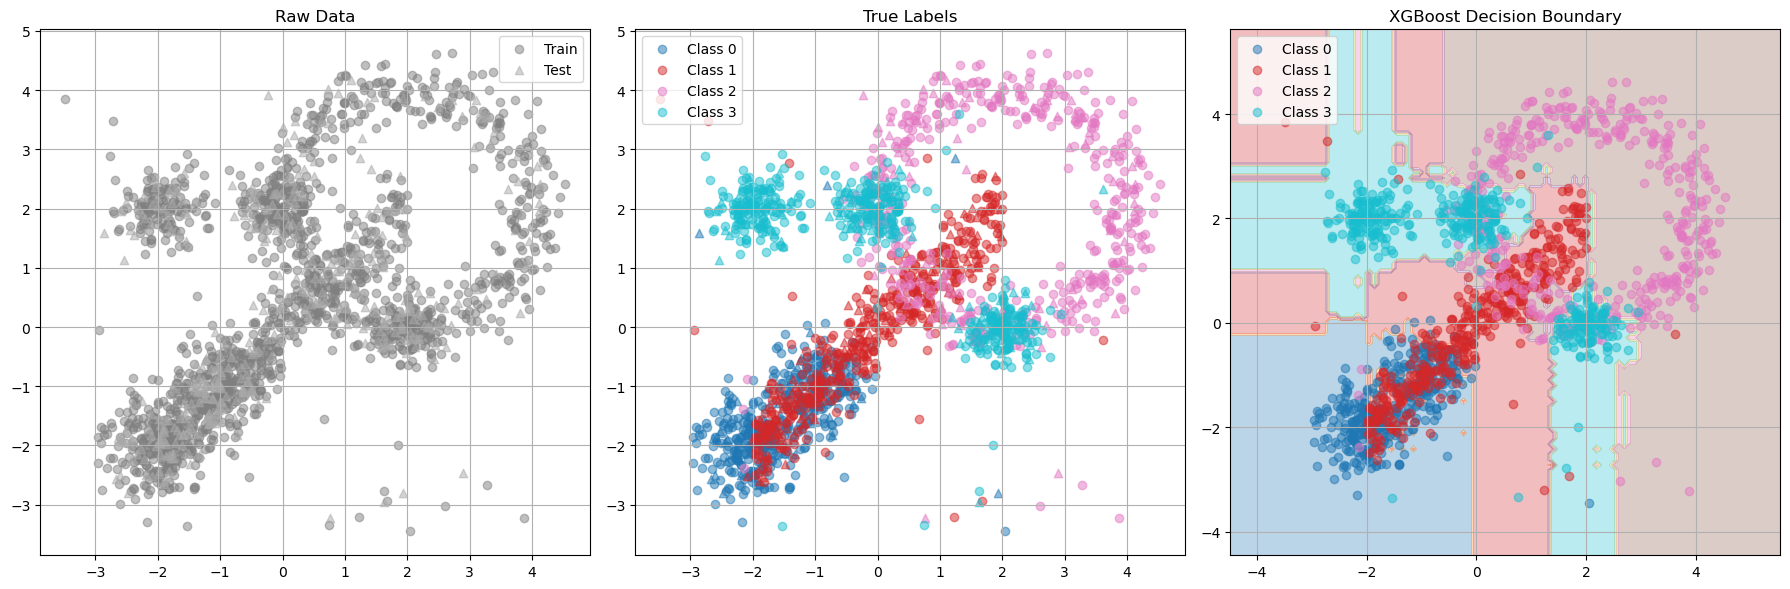

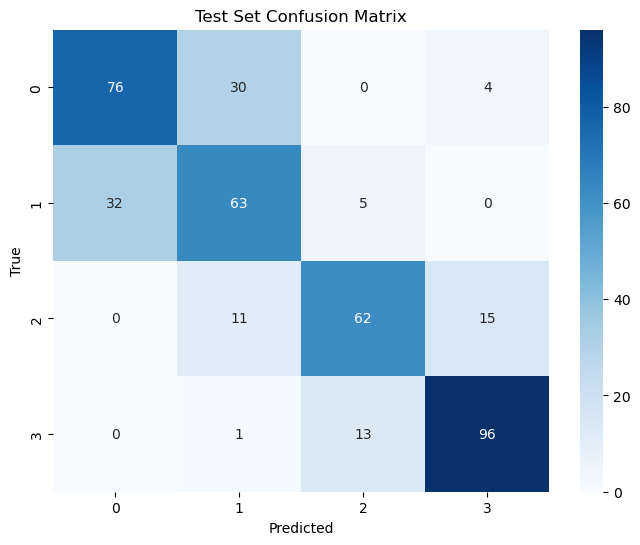

In [16]:
def main():
    
    X, y = generate_balanced_data(n_samples=2000, noise_level=0.4)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = XGBoostClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        min_child_weight=1.0,
        gamma=0.1,
        lambda_l2=1.0,
        colsample_bytree=0.8,
        subsample=0.8,
    )

    print("Training XGBoost model...")
    model.fit(X_train, y_train)

    print("Making predictions...")
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_metrics = ClassificationMetrics(y_train, y_train_pred)
    test_metrics = ClassificationMetrics(y_test, y_test_pred)

    print("\nTraining Set Performance:")
    print(train_metrics.generate_report())
    print("\nTest Set Performance:")
    print(test_metrics.generate_report())

    print("\nGenerating visualizations...")
    plot_results(X_train, X_test, y_train, y_test, model)
    plot_confusion_matrix(test_metrics.confusion_matrix, title='Test Set Confusion Matrix')

if __name__ == "__main__":
    main()